In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
import PIL
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
from tqdm import tqdm
import tensorflow_addons as tfa
import random
from sklearn.preprocessing import MultiLabelBinarizer
from PIL import Image
from sklearn.model_selection import train_test_split
pd.set_option("display.max_columns", None)

print('success')

success


In [3]:
train = pd.read_csv('/kaggle/input/plant-pathology-2021-fgvc8/train.csv')
print(train.shape)

(18632, 2)


In [4]:
train['labels'] = train['labels'].apply(lambda string: string.split(' '))
train

,image,labels
0,800113bb65efe69e.jpg,[healthy]
1,8002cb321f8bfcdf.jpg,"[scab, frog_eye_leaf_spot, complex]"
2,80070f7fb5e2ccaa.jpg,[scab]
3,80077517781fb94f.jpg,[scab]
4,800cbf0ff87721f8.jpg,[complex]
...,...,...
18627,fffb900a92289a33.jpg,[healthy]
18628,fffc488fa4c0e80c.jpg,[scab]
18629,fffc94e092a59086.jpg,[rust]
18630,fffe105cf6808292.jpg,"[scab, frog_eye_leaf_spot]"


Index(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust',
       'scab'],
      dtype='object')
complex               2151
frog_eye_leaf_spot    4352
healthy               4624
powdery_mildew        1271
rust                  2077
scab                  5712
dtype: int64
['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab']


<AxesSubplot:>

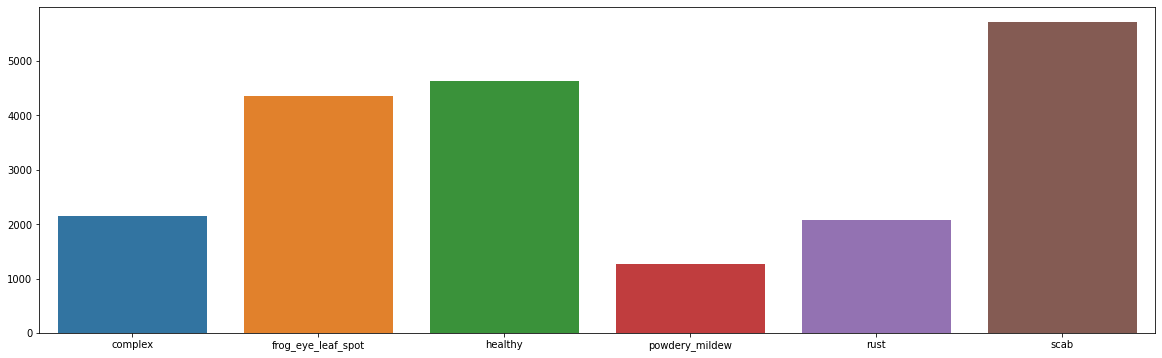

In [38]:
s = list(train['labels'])
mlb = MultiLabelBinarizer()
trainx = pd.DataFrame(mlb.fit_transform(s), columns=mlb.classes_, index=train.index)
print(trainx.columns)
print(trainx.sum())

labels = list(trainx.sum().keys())
print(labels)
label_counts = trainx.sum().values.tolist()

fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.barplot(x= labels, y= label_counts, ax=ax)

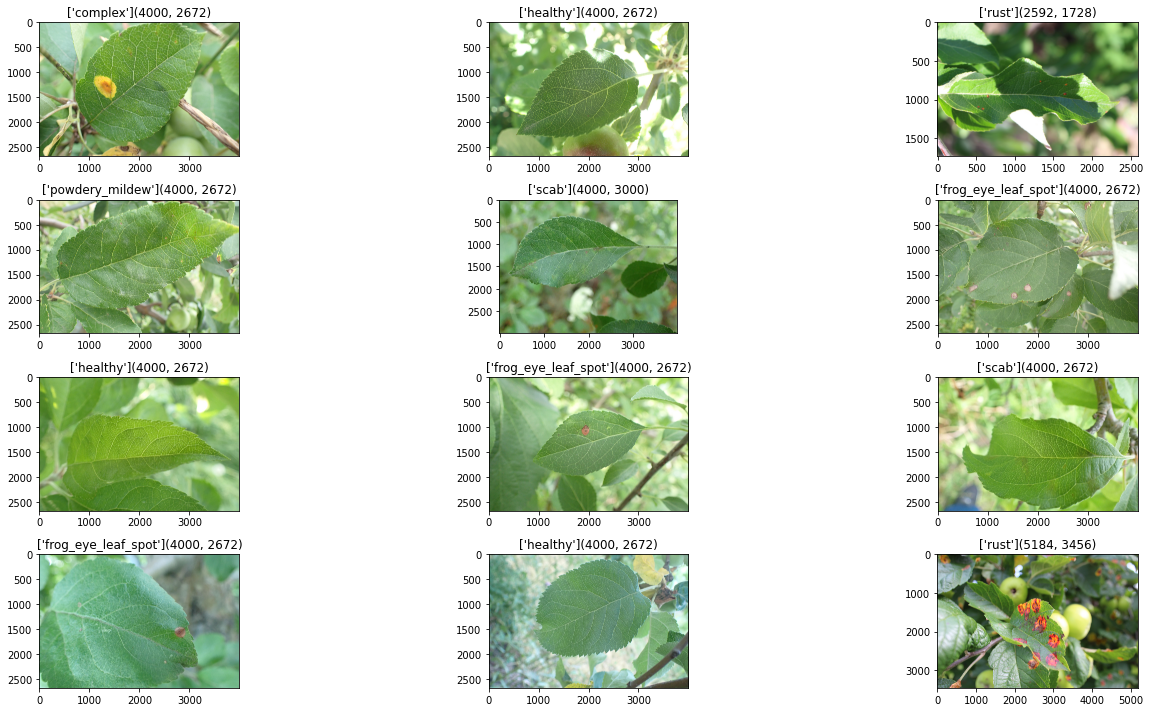

In [39]:
fig1 = plt.figure(figsize=(26,10))

for i in range(1, 13):
    
    rand =  random.randrange(1, len(list(train['image'])))
    sample = os.path.join('/kaggle/input/plant-pathology-2021-fgvc8/train_images/', train['image'][rand])
    
    img = Image.open(sample)
    
    ax = fig1.add_subplot(4,3,i)
    ax.imshow(img)
    
    title = f"{train['labels'][rand]}{img.size}"
    plt.title(title)
    
    fig1.tight_layout()

In [5]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1/255.0,
                            rotation_range=5,
                            zoom_range=0.1,
                            shear_range=0.05,
                            horizontal_flip=True,
                            validation_split=0.1)

train_generator = datagen.flow_from_dataframe(
    train,
    directory='/kaggle/input/plant-pathology-2021-fgvc8/train_images',
    subset='training',
    x_col='image',
    y_col='labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=444
    )

#'../input/plant-pathology-2021-fgvc8/train_images'
valid_generator = datagen.flow_from_dataframe(
    train,
    directory='/kaggle/input/plant-pathology-2021-fgvc8/train_images',
    subset='validation',
    x_col='image',
    y_col='labels',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=444
    )


Found 16769 validated image filenames belonging to 6 classes.
Found 1863 validated image filenames belonging to 6 classes.


In [6]:
import h5py

In [7]:
seed = 1200
tf.random.set_seed(seed)

# weights_path = '../input/keras-pretrained-models/inception_resnet_v2_weights_tf_dim_ordering_tf_kernels_notop.h5'
# model = keras.applications.InceptionResNetV2(weights=weights_path, include_top=False, input_shape=(224, 224, 3))
model = keras.applications.NASNetMobile(input_shape=(224, 224, 3), include_top=False, weights='imagenet', classes=1000)
print(model.input)
print(model.output)

2022-03-25 02:53:40.794920: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 02:53:40.891841: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 02:53:40.892556: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-25 02:53:40.893677: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

20004864/19993432 [==============================] - 0s 0us/step
KerasTensor(type_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 7, 7, 1056), dtype=tf.float32, name=None), name='activation_187/Relu:0', description="created by layer 'activation_187'")


In [8]:
new_model = tf.keras.Sequential([
    model,
    keras.layers.GlobalAveragePooling2D(),
    keras.layers.Dense(6, 
        kernel_initializer=keras.initializers.RandomUniform(seed=seed),
        bias_initializer=keras.initializers.Zeros(), name='dense_top', activation='sigmoid')
])

# Freezing the weights
for layer in new_model.layers[:-1]:
    layer.trainable=False
    
new_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
NASNet (Functional)          (None, 7, 7, 1056)        4269716   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1056)              0         
_________________________________________________________________
dense_top (Dense)            (None, 6)                 6342      
Total params: 4,276,058
Trainable params: 6,342
Non-trainable params: 4,269,716
_________________________________________________________________


In [44]:
from tensorflow.keras.callbacks import EarlyStopping
import PIL
f1 = tfa.metrics.F1Score(num_classes=6,average='macro')

new_model.compile(optimizer="rmsprop", loss='categorical_crossentropy',
                  metrics=['accuracy',f1])
callbacks = keras.callbacks.EarlyStopping(monitor=f1, patience=4, mode='max', restore_best_weights=True)
history = new_model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    epochs=50,
                    steps_per_epoch=train_generator.samples//256, # = 58
                    validation_steps=valid_generator.samples//128,
                    callbacks=callbacks)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50
65/65 [==============================] - 499s 7s/step - loss: 0.4246 - accuracy: 0.3851 - f1_score: 0.2757 - val_loss: 0.3915 - val_accuracy: 0.4621 - val_f1_score: 0.4206
Epoch 2/50
65/65 [==============================] - 459s 7s/step - loss: 0.3797 - accuracy: 0.4865 - f1_score: 0.4195 - val_loss: 0.3745 - val_accuracy: 0.4732 - val_f1_score: 0.4356
Epoch 3/50
65/65 [==============================] - 450s 7s/step - loss: 0.3575 - accuracy: 0.5193 - f1_score: 0.4836 - val_loss: 0.3578 - val_accuracy: 0.4732 - val_f1_score: 0.4243
Epoch 4/50
65/65 [==============================] - 462s 7s/step - loss: 0.3397 - accuracy: 0.5500 - f1_score: 0.4973 - val_loss: 0.3392 - val_accuracy: 0.5268 - val_f1_score: 0.4937
Epoch 5/50
65/65 [==============================] - 458s 7s/step - loss: 0.3376 - accuracy: 0.5486 - f1_score: 0.4952 - val_loss: 0.3430 - val_accuracy: 0.5469 - val_f1_score: 0.4878
Epoch 6/50
65/65 [==============================] - 463s 7s/step - loss: 0.3300 - acc

In [15]:
# test = pd.read_csv('../input/plant-pathology-2021-fgvc8/sample_submission.csv')
_, test = train_test_split(train, test_size=0.1)
for img_name in tqdm(test['image']):
    path = '../input/plant-pathology-2021-fgvc8/train_images/'+str(img_name)
    with PIL.Image.open(path) as img:
        img = img.resize((256,256))
        img.save(f'./{img_name}')

100%|██████████| 1864/1864 [06:54<00:00,  4.50it/s]


In [9]:

test_data = datagen.flow_from_dataframe(
    test,
    directory = './',
    x_col="image",
    y_col= None,
    color_mode="rgb",
    target_size = (256,256),
    classes=None,
    class_mode=None,
    batch_size=32,
    shuffle=False,
    seed=40,
)

preds = new_model.predict(test_data)
print(preds)
preds = preds.tolist()

indices = []
for pred in preds:
    temp = []
    for category in pred:
        if category>=0.3:
            temp.append(pred.index(category))
    if temp!=[]:
        indices.append(temp)
    else:
        temp.append(np.argmax(pred))
        indices.append(temp)
    
print(indices)
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

testlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    testlabels.append(' '.join(temp))

print(testlabels)

NameError: name 'test' is not defined

In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
print(labels)

testlabels = []


for image in indices:
    temp = []
    for i in image:
        temp.append(str(labels[i]))
    testlabels.append(' '.join(temp))

print(testlabels)

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(testlabels, test)

In [ ]:
# accuracy
plt.figure(figsize=(15,6))
epoch_list = list(range(1, len(history.history['accuracy']) + 1))
plt.plot(epoch_list, history.history['accuracy'],label='accuracy')
plt.plot(epoch_list, history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('epoches')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [ ]:
# loss
plt.figure(figsize=(15,6))
epoch__list = list(range(1,len(history.history['loss'])+1))
plt.plot(epoch__list, history.history['loss'],label='loss')
plt.plot(epoch__list, history.history['val_loss'],label='val_loss')
plt.xlabel('epoches')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
# f1  score
plt.figure(figsize=(15,6))
epoch__list = list(range(1,len(history.history['f1_score'])+1))
plt.plot(epoch__list, history.history['f1_score'],label='f1_score')
plt.plot(epoch__list, history.history['val_f1_score'],label='val_f1_score')
plt.xlabel('epoches')
plt.ylabel('f1')
plt.legend()
plt.show()

In [ ]:
arr1 = history.history['loss']
result1 = sum(arr1)
print(f"loss_av : {result1 / len(arr1)}")

arr2 = history.history['accuracy']
result2 = sum(arr2)
print(f"accuracy_av : {result2 / len(arr2)}")

arr3 = history.history['val_loss']
result3 = sum(arr3)
print(f"val_loss_av : {result3 / len(arr3)}")

arr4 = history.history['val_accuracy']
result4 = sum(arr4)
print(f"val_accuracy_av : {result4 / len(arr4)}")